# モデル学習

## Library Import

In [81]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

import datetime as dt

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [82]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../output/intermediate_file/'
model_path = '../output/model/'
oof_path = '../output/oof/'
fi_path = '../output/fi/'

# スクリプトのバージョン指定
fe_ver = 3
training_ver = 3
run_ver = 3 # モデル変更のない特徴量の更新についてはこちらで管理

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [83]:
train_df = pd.read_parquet(f'{intermediate_path}train_df_fe_v{fe_ver}.parquet')

In [84]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [85]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

In [86]:
# tag_prefixes = (
#     '土地価格_',
#     '建物構造・性能_',
#     '建物設備（給排水・インフラ）_',
#     '立地プレミアム_',
#     '環境プレミアム_',
#     '専有部分設備_',
#     '用途・投資セグメント_売買ステータス_',
#     '用途・投資セグメント_不動産の証明書・性能評価_',
# )

# tag_cols = [
#     c for c in train_df.columns
#     if c.startswith(tag_prefixes)
# ]

In [87]:
# remove_cols = ['count_neighbors_1000m', 'door_to_station_min_log', 'tochi_area_log', 'shikichi_area_log'] + tag_cols
# fe_cols = [c for c in fe_cols if c not in remove_cols]

#### カテゴリ型へ変更

In [88]:
cat_cols = ['building_category', 'land_toshi', 'land_area_kind', 'land_youto', 'building_land_chimoku',
            'land_road_cond', 'building_area_kind', 'access_zone'
]

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [89]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()
train_df[obj_cols] = train_df[obj_cols].astype('category')

## モデルの学習

In [90]:
house_idx = train_df['building_category'] == 'house'
non_house_idx = ~house_idx

train_df_house = train_df[house_idx]
train_df_all = train_df[non_house_idx]

all_base_cols = fe_cols.copy()
all_low_cols = fe_cols.copy()
house_base_cols = fe_cols.copy()
house_low_cols = fe_cols.copy()

In [91]:
LOW_PRICE_TH_ALL = 10_000_000  # 低価格の閾値（1,000万円）
LOW_PRICE_TH_HOUSE = 20_000_000  # 低価格の閾値（2,000万円）
year_col = 'target_year'

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 100,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

low_params = {
    'num_leaves': 64,
    'min_child_samples': 30,
}

In [92]:
mono_map = {
    # 単調増加
    "land_theoretical_price_weighted": 1,
    "land_theoretical_price": 1,
    "log_land_price": 1,
    "log_weighted_land_price_3": 1,
    "mean_price_500m_log": 1,
    "mean_price_1000m_log": 1,
    "mean_price_2000m_log": 1,
    "mean_price_500m_mansion_log": 1,
    "mean_price_1000m_mansion_log": 1,
    "mean_price_2000m_mansion_log": 1,
    "mean_price_500m_house_log": 1,
    "mean_price_1000m_house_log": 1,
    "mean_price_2000m_house_log": 1,
    # "senyu_area_log": 1,
    # "nobeyuka_area_log": 1,

    # 単調減少
    "built_diff": -1,
    "door_to_station_min_log": -1,
    # "distance_to_landpoint_m": -1,
    # "listing_months": -1,
}

#### 関数

In [93]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))

In [94]:
def make_monotone_constraints(feature_names):
    return [mono_map.get(col, 0) for col in feature_names]

In [95]:
def _infer_te_source_col(te_col: str) -> str:
    # "xxx_te" -> "xxx"
    return te_col[:-3] if te_col.endswith("_te") else te_col

def fit_target_encoding_map(
    s_cat: pd.Series,
    y: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
) -> tuple[pd.Series, float]:
    """
    1列のカテゴリ s_cat をターゲット y で target encoding するための mapping を作る。
    smoothing: 大きいほど全体平均に寄る（過学習防止）
    """
    s_cat = s_cat.astype("object")
    y = y.astype(float)

    prior = float(y.mean())

    stats = (
        pd.DataFrame({"cat": s_cat, "y": y})
          .groupby("cat")["y"]
          .agg(["count", "mean"])
    )

    # count が小さいカテゴリは prior に寄せる（smoothing + min_samples_leaf）
    count = stats["count"].astype(float)
    mean  = stats["mean"].astype(float)

    # smoothing 係数（一般的な ridge-like smoothing）
    # enc = (count*mean + smoothing*prior) / (count + smoothing)
    enc = (count * mean + smoothing * prior) / (count + smoothing)

    # さらに min_samples_leaf 未満は prior へ
    if min_samples_leaf > 1:
        enc[count < min_samples_leaf] = prior

    return enc, prior

def apply_target_encoding(
    s_cat: pd.Series,
    mapping: pd.Series,
    prior: float,
) -> pd.Series:
    s_cat = s_cat.astype("object")
    return s_cat.map(mapping).fillna(prior).astype(float)

def recompute_te_for_fold(
    train_df: pd.DataFrame,
    tr_idx: pd.Index,
    apply_idx_list: list[pd.Index],
    te_cols: list[str],
    y_tr: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
    verbose: bool = True,
) -> dict:
    """
    te_cols（例: eki_name1_te）の各列について、
    学習fold（tr_idx）だけでTEをfitし、apply_idx_list の各Indexへ適用する。

    返り値: {te_col: {"src_col":..., "mapping":..., "prior":...}} （必要なら保存用）
    """
    te_meta = {}

    for te_col in te_cols:
        src_col = _infer_te_source_col(te_col)
        if src_col not in train_df.columns:
            if verbose:
                print(f"[WARN] TE元列が見つからないためスキップ: {te_col} (src={src_col})")
            continue

        mapping, prior = fit_target_encoding_map(
            train_df.loc[tr_idx, src_col],
            y_tr.loc[tr_idx],
            smoothing=smoothing,
            min_samples_leaf=min_samples_leaf,
        )

        # 各適用先（train/val/ho など）へ適用
        for idx in apply_idx_list:
            train_df.loc[idx, te_col] = apply_target_encoding(
                train_df.loc[idx, src_col],
                mapping,
                prior
            ).values

        te_meta[te_col] = {"src_col": src_col, "mapping": mapping, "prior": prior}

    return te_meta

In [98]:
def run_cv_with_low_model(
    train_df,
    base_cols,
    low_cols,
    target_col,
    year_col,
    base_params,
    low_params,
    low_price_th=10_000_000,
    sigma_th=0.075,          # ★ 新規：不確実性しきい値
    n_splits=5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    y = train_df[target_col].astype(float)
    y_log = np.log(y)

    mask_train_cv = train_df[year_col] <= 2021
    mask_holdout  = train_df[year_col] == 2022

    idx_cv = train_df.index[mask_train_cv]
    idx_ho = train_df.index[mask_holdout]

    X_cv_base = train_df.loc[idx_cv, base_cols]
    y_cv_log  = y_log.loc[idx_cv]
    groups_cv = train_df.loc[idx_cv, 'building_id']

    y_ho = y.loc[idx_ho]

    print(f'CV 用データ: {len(idx_cv)} 行')
    print(f'Holdout 用データ (2022): {len(idx_ho)} 行\n')

    # ===== OOF =====
    oof_pred_log      = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_pred_log_base = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_pred_log_low  = pd.Series(np.nan, index=train_df.index, dtype=float)
    oof_used_low      = pd.Series(False,  index=train_df.index, dtype=bool)

    # ===== HO（fold平均）=====
    ho_pred_log_accum      = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_pred_log_base_accum = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_pred_log_low_accum  = pd.Series(0.0, index=idx_ho, dtype=float)
    ho_used_low_votes      = pd.Series(0.0, index=idx_ho, dtype=float)

    fi_list_base = []
    fi_list_low  = []

    # ★ fold ごとの HO base 予測保存（σ算出用）
    ho_base_log_by_fold = []

    gkf = GroupKFold(n_splits=n_splits)
    print('=== GroupKFold CV 開始 ===')

    te_cols_base = [c for c in base_cols if c.endswith('_te')]
    te_cols_low  = [c for c in low_cols  if c.endswith('_te')]
    te_cols_all  = sorted(set(te_cols_base + te_cols_low))

    for fold, (tr_idx_local, va_idx_local) in enumerate(
        gkf.split(X_cv_base, y_cv_log, groups_cv), 1
    ):
        tr_idx = idx_cv[tr_idx_local]
        va_idx = idx_cv[va_idx_local]

        # --- fold内TE再計算 ---
        if te_cols_all:
            _ = recompute_te_for_fold(
                train_df=train_df,
                tr_idx=tr_idx,
                apply_idx_list=[tr_idx, va_idx, idx_ho],
                te_cols=te_cols_all,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=(fold == 1),
            )

        # ===== base fit =====
        X_tr_base = train_df.loc[tr_idx, base_cols]
        y_tr_log  = y_log.loc[tr_idx]
        base_model = lgb.LGBMRegressor(**base_params)
        base_model.fit(X_tr_base, y_tr_log)

        # ===== low fit（真値で抽出 OK）=====
        tr_idx_low = tr_idx[y.loc[tr_idx] <= low_price_th]
        X_tr_low = train_df.loc[tr_idx_low, low_cols]
        y_tr_low_log = y_log.loc[tr_idx_low]
        low_model = lgb.LGBMRegressor(**low_params)
        low_model.fit(X_tr_low, y_tr_low_log)

        # ===== OOF predict（base / low だけ）=====
        X_va_base = train_df.loc[va_idx, base_cols]
        X_va_low  = train_df.loc[va_idx, low_cols]

        va_base_log = base_model.predict(X_va_base)
        va_low_log  = low_model.predict(X_va_low)

        oof_pred_log_base.loc[va_idx] = va_base_log
        oof_pred_log_low.loc[va_idx]  = va_low_log

        # ===== HO predict（保存）=====
        X_ho_base = train_df.loc[idx_ho, base_cols]
        X_ho_low  = train_df.loc[idx_ho, low_cols]

        ho_base_log = base_model.predict(X_ho_base)
        ho_low_log  = low_model.predict(X_ho_low)

        ho_base_log_by_fold.append(
            pd.Series(ho_base_log, index=idx_ho)
        )

        ho_pred_log_base_accum += ho_base_log / n_splits
        ho_pred_log_low_accum  += ho_low_log  / n_splits

        # ===== fold MAPE（base only）=====
        fold_mape = mape(y.loc[va_idx], np.exp(va_base_log))
        print(f'Fold {fold}: val MAPE (base)={fold_mape:.4f}')

        # ===== FI =====
        fi_list_base.append(pd.DataFrame({
            'feature': base_cols,
            'importance': base_model.booster_.feature_importance(importance_type='gain'),
            'fold': fold
        }))
        fi_list_low.append(pd.DataFrame({
            'feature': low_cols,
            'importance': low_model.booster_.feature_importance(importance_type='gain'),
            'fold': fold
        }))

    print('=== CV 完了 ===\n')

    # ===== HO の μ, σ =====
    ho_base_log_stack = pd.concat(ho_base_log_by_fold, axis=1)
    ho_base_mu    = ho_base_log_stack.mean(axis=1)
    ho_base_sigma = ho_base_log_stack.std(axis=1)


    return (
        y, y_ho,

        # --- OOF（base / low の生予測） ---
        oof_pred_log_base,
        oof_pred_log_low,

        # --- HO（base / low の生予測：fold平均） ---
        ho_pred_log_base_accum,
        ho_pred_log_low_accum,

        # --- HO 不確実性 ---
        ho_base_mu,
        ho_base_sigma,

        # --- Feature Importance ---
        fi_list_base,
        fi_list_low,
    )

#### house以外モデル

In [ ]:
(
    y_all, y_ho_all,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_all_base, oof_pred_log_all_low,

    # --- HO（base / low の生予測） ---
    ho_pred_log_all_base, ho_pred_log_all_low,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_all_base, fi_list_all_low,
) = run_cv_with_low_model(
    train_df=train_df_all,
    base_cols=all_base_cols,
    low_cols=all_low_cols,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_ALL,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38984
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 360
[LightGBM] [Info] Start training from score 16.904156
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a lar

In [100]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_all_base)

y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all_base.loc[oof_mask_valid])

oof_mape_all = mape(y_oof, oof_pred_all)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_all:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_all_base)
ho_mape_base = mape(y_ho_all, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

# =====================
# HO MAPE（with low）
# =====================
sigma_th = ho_base_sigma.quantile(0.80)

mask_low = (
    (ho_base_mu <= np.log(LOW_PRICE_TH_ALL)) &
    (ho_base_sigma >= sigma_th)
)

ho_final_log = ho_pred_log_all_base.copy()
ho_final_log[mask_low] = ho_pred_log_all_low[mask_low]

ho_pred = np.exp(ho_final_log)
ho_mape = mape(y_ho_all, ho_pred)

print('HO MAPE:', ho_mape)
print('low applied rate:', mask_low.mean())

OOF MAPE (2019–2021, base only): 0.142772
2022 hold-out MAPE (base only): 0.125653
HO MAPE: 0.12502005451845583
low applied rate: 0.03155104543746167


In [ ]:
#　v1
# OOF MAPE (2019–2021, base only): 0.142585
# 2022 hold-out MAPE (base only): 0.125322
# HO MAPE: 0.12479174560803813
# low applied rate: 0.031412576899491625

# v2
# OOF MAPE (2019–2021, base only): 0.143018
# 2022 hold-out MAPE (base only): 0.125451
# HO MAPE: 0.12489424012633638
# low applied rate: 0.03238185666528198

# v3
# OOF MAPE (2019–2021, base only): 0.142772
# 2022 hold-out MAPE (base only): 0.125653
# HO MAPE: 0.12502005451845583
# low applied rate: 0.03155104543746167

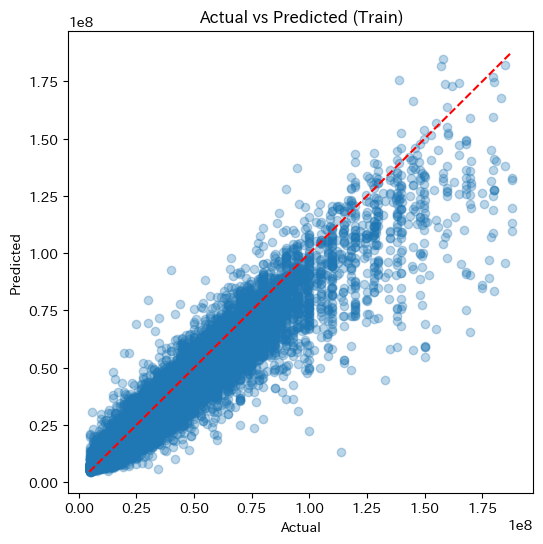

In [102]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_all, ho_pred, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_all.min(), ho_pred.min())
max_val = max(y_ho_all.max(), ho_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

#### houseモデル

In [103]:
(
    y_house, y_ho_house,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_house_base, oof_pred_log_house_low,

    # --- HO（base / low の生予測） ---
    ho_pred_log_house_base, ho_pred_log_house_low,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_house_base, fi_list_house_low,
) = run_cv_with_low_model(
    train_df=train_df_house,
    base_cols=house_base_cols,
    low_cols=house_low_cols,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_HOUSE,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37325
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 323
[LightGBM] [Info] Start training from score 16.782947
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a larg

In [104]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_house_base)

y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house_base.loc[oof_mask_valid])

oof_mape_house = mape(y_oof, oof_pred_house)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_house:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_house_base)
ho_mape_base = mape(y_ho_house, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

# =====================
# HO MAPE（with low）
# =====================
sigma_th = ho_base_sigma.quantile(0.95)

mask_low = (
    (ho_base_mu <= np.log(LOW_PRICE_TH_HOUSE)) &
    (ho_base_sigma >= sigma_th)
)

ho_final_log = ho_pred_log_house_base.copy()
ho_final_log[mask_low] = ho_pred_log_house_low[mask_low]

ho_pred = np.exp(ho_final_log)
ho_mape = mape(y_ho_house, ho_pred)

print('HO MAPE:', ho_mape)
print('low applied rate:', mask_low.mean())

OOF MAPE (2019–2021, base only): 0.190054
2022 hold-out MAPE (base only): 0.166641
HO MAPE: 0.16831171182502308
low applied rate: 0.028349524517468538


In [ ]:
#　v1
# OOF MAPE (2019–2021, base only): 0.189841
# 2022 hold-out MAPE (base only): 0.166467
# HO MAPE: 0.1681746903743582
# low applied rate: 0.027965037295260554

# v2
# OOF MAPE (2019–2021, base only): 0.190091
# 2022 hold-out MAPE (base only): 0.166705
# HO MAPE: 0.16847613798008104
# low applied rate: 0.027888139850818956

# v3
# OOF MAPE (2019–2021, base only): 0.190054
# 2022 hold-out MAPE (base only): 0.166641
# HO MAPE: 0.16831171182502308
# low applied rate: 0.028349524517468538

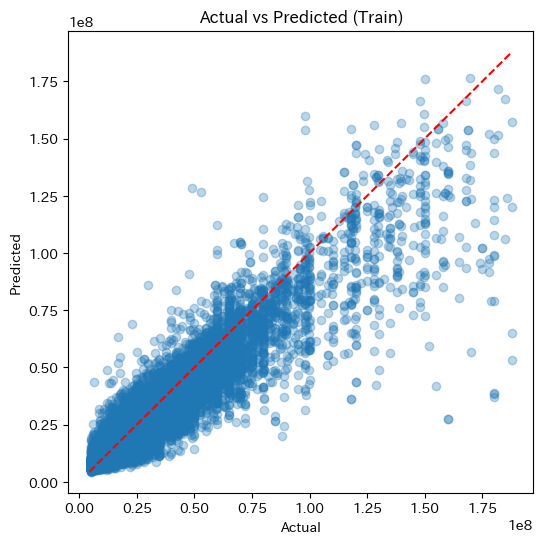

In [106]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho_house, ho_pred, alpha=0.3)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train)')

# 45度線（完璧な予測ライン）
min_val = min(y_ho_house.min(), ho_pred.min())
max_val = max(y_ho_house.max(), ho_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 特徴量重要度

In [107]:
all_base_fi = (
    pd.concat(fi_list_all_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

all_low_fi = (
    pd.concat(fi_list_all_low)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

house_base_fi = (
    pd.concat(fi_list_house_base)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

house_low_fi = (
    pd.concat(fi_list_house_low)
      .groupby('feature')['importance']
      .mean()
      .reset_index()
      .sort_values('importance', ascending=False)
)

In [108]:
all_base_fi.to_csv(f'{fi_path}feature_importance_all_base_{run_ver}.csv', index=False)
all_low_fi.to_csv(f'{fi_path}feature_importance_all_low_{run_ver}.csv', index=False)
house_base_fi.to_csv(f'{fi_path}feature_importance_house_base_{run_ver}.csv', index=False)
house_low_fi.to_csv(f'{fi_path}feature_importance_house_low_{run_ver}.csv', index=False)

#### 特徴量重要度==0を削除

In [109]:
excluded_fe_all_base = all_base_fi.query('importance == 0')['feature'].tolist()
excluded_fe_all_low  = all_low_fi.query('importance == 0')['feature'].tolist()
excluded_fe_house_base = house_base_fi.query('importance == 0')['feature'].tolist()
excluded_fe_house_low  = house_low_fi.query('importance == 0')['feature'].tolist()

print(f'[ALL Base] Removed {len(excluded_fe_all_base)} features')
print(f'[ALL Low]  Removed {len(excluded_fe_all_low)} features')
print(f'[HOUSEBase] Removed {len(excluded_fe_house_base)} features')
print(f'[HOUSE Low]  Removed {len(excluded_fe_house_low)} features')

all_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_base]
all_low_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_low]
house_base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_base]
house_low_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_low]

[ALL Base] Removed 62 features
[ALL Low]  Removed 144 features
[HOUSEBase] Removed 85 features
[HOUSE Low]  Removed 158 features


#### house以外モデル

In [120]:
(
    y_all, y_ho_all,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_all_base, oof_pred_log_all_low,

    # --- HO（base / low の生予測） ---
    ho_pred_log_all_base, ho_pred_log_all_low,

    # --- HO 不確実性 ---
    ho_base_mu_all, ho_base_sigma_all,

    # --- Feature Importance ---
    fi_list_all_base, fi_list_all_low,
) = run_cv_with_low_model(
    train_df=train_df_all,
    base_cols=all_base_cols_filtered,
    low_cols=all_low_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_ALL,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 159915 行
Holdout 用データ (2022): 50553 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38842
[LightGBM] [Info] Number of data points in the train set: 127932, number of used features: 327
[LightGBM] [Info] Start training from score 16.904156
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a lar

In [123]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_all_base)

y_oof = y_all.loc[oof_mask_valid]
oof_pred_all = np.exp(oof_pred_log_all_base.loc[oof_mask_valid])

oof_mape_all = mape(y_oof, oof_pred_all)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_all:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_all_base)
ho_mape_base = mape(y_ho_all, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

# =====================
# HO MAPE（with low）
# =====================
sigma_th = ho_base_sigma_all.quantile(0.80)

mask_low = (
    (ho_base_mu_all <= np.log(LOW_PRICE_TH_ALL)) &
    (ho_base_sigma_all >= sigma_th)
)

ho_final_log = ho_pred_log_all_base.copy()
ho_final_log[mask_low] = ho_pred_log_all_low[mask_low]

ho_pred_all = np.exp(ho_final_log)
ho_mape = mape(y_ho_all, ho_pred_all)

print('HO MAPE:', ho_mape)
print('low applied rate:', mask_low.mean())

OOF MAPE (2019–2021, base only): 0.142329
2022 hold-out MAPE (base only): 0.125515
HO MAPE: 0.1250364556653625
low applied rate: 0.03155104543746167


In [127]:
low_mu_rate_ho = (ho_base_mu_all <= np.log(LOW_PRICE_TH_ALL)).mean()
sigma_th_ho = np.quantile(ho_base_sigma_all, 0.70)
both_rate_ho = ((ho_base_mu_all <= np.log(LOW_PRICE_TH_ALL)) & (ho_base_sigma_all >= sigma_th_ho)).mean()

print('HO mu<=th rate:', low_mu_rate_ho)
print('HO both rate:', both_rate_ho)

HO mu<=th rate: 0.09483116728977509
HO both rate: 0.04286590311158586


In [126]:
sigma_th_ho

0.056239323401596014

#### houseモデル

In [112]:
(
    y_house, y_ho_house,

    # --- OOF（base / low の生予測） ---
    oof_pred_log_house_base, oof_pred_log_house_low,

    # --- HO（base / low の生予測） ---
    ho_pred_log_house_base, ho_pred_log_house_low,

    # --- HO 不確実性 ---
    ho_base_mu, ho_base_sigma,

    # --- Feature Importance ---
    fi_list_house_base, fi_list_house_low,
) = run_cv_with_low_model(
    train_df=train_df_house,
    base_cols=house_base_cols_filtered,
    low_cols=house_low_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    low_price_th=LOW_PRICE_TH_HOUSE,
    base_params=base_params,
    low_params=low_params,
)

CV 用データ: 114443 行
Holdout 用データ (2022): 39013 行

=== GroupKFold CV 開始 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37286
[LightGBM] [Info] Number of data points in the train set: 91554, number of used features: 304
[LightGBM] [Info] Start training from score 16.782947
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a larg

In [113]:
# =====================
# OOF MAPE（base only）
# =====================
oof_mask_valid = ~np.isnan(oof_pred_log_house_base)

y_oof = y_house.loc[oof_mask_valid]
oof_pred_house = np.exp(oof_pred_log_house_base.loc[oof_mask_valid])

oof_mape_house = mape(y_oof, oof_pred_house)

print(f'OOF MAPE (2019–2021, base only): {oof_mape_house:.6f}')

# =====================
# HO MAPE（base only）
# =====================
ho_pred_base = np.exp(ho_pred_log_house_base)
ho_mape_base = mape(y_ho_house, ho_pred_base)

print(f'2022 hold-out MAPE (base only): {ho_mape_base:.6f}')

# =====================
# HO MAPE（with low）
# =====================
sigma_th = ho_base_sigma.quantile(0.95)

mask_low = (
    (ho_base_mu <= np.log(LOW_PRICE_TH_HOUSE)) &
    (ho_base_sigma >= sigma_th)
)

ho_final_log = ho_pred_log_house_base.copy()
ho_final_log[mask_low] = ho_pred_log_house_low[mask_low]

ho_pred_house = np.exp(ho_final_log)
ho_mape = mape(y_ho_house, ho_pred_house)

print('HO MAPE:', ho_mape)
print('low applied rate:', mask_low.mean())

OOF MAPE (2019–2021, base only): 0.189598
2022 hold-out MAPE (base only): 0.166483
HO MAPE: 0.16817699487053328
low applied rate: 0.028170097147104813


#### 学習データの予測結果出力

In [114]:
# ============================================================
# 1) 予測結果を格納する DataFrame
# ============================================================
train_result_df_all = train_df_all[fe_cols + [target_col]].copy()
train_result_df_house = train_df_house[fe_cols + [target_col]].copy()

train_result_df_all['oof_pred'] = np.nan
train_result_df_all['ho_pred'] = np.nan
train_result_df_house['oof_pred'] = np.nan
train_result_df_house['ho_pred'] = np.nan

# --- HO のマスク（2022年） ---
mask_ho_all = train_result_df_all['target_ym'].astype(str).str.startswith('2022')
mask_ho_house = train_result_df_house['target_ym'].astype(str).str.startswith('2022')

# index が完全一致するのでそのまま代入可
train_result_df_all.loc[~mask_ho_all,     'oof_pred'] = oof_pred_all
train_result_df_all.loc[mask_ho_all,      'ho_pred'] = ho_pred_all
train_result_df_house.loc[~mask_ho_house, 'oof_pred'] = oof_pred_house
train_result_df_house.loc[mask_ho_house,  'ho_pred'] = ho_pred_house

# 保存
train_result_df = pd.concat([train_result_df_all, train_result_df_house], axis=0)
train_result_df.to_csv(f'{oof_path}oof_{today}_{run_ver}.csv', index=False)

## 最終モデル

In [115]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
all_base_cols = all_base_cols_filtered.copy()
all_low_cols = all_low_cols_filtered.copy()

house_base_cols = house_base_cols_filtered.copy()
house_low_cols = house_low_cols_filtered.copy()

y_all     = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

# building_category で house / 非 house に分割
idx_house      = train_df.index[house_idx]
idx_non_house  = train_df.index[~house_idx]   # house 以外

In [116]:
from sklearn.model_selection import KFold

def train_kfold_models_with_te(
    train_df: pd.DataFrame,
    idx: pd.Index,
    feature_cols: list[str],
    y_log: pd.Series,
    params: dict,
    n_splits: int = 5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    """
    idx の範囲で KFold を回し、各foldで *_te を学習foldのみで再計算してから model.fit する。
    """
    models = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # TE対象列
    te_cols = [c for c in feature_cols if c.endswith("_te")]

    # KFoldは位置で返すので、idx配列を使って実Indexに戻す
    idx_array = np.array(idx)

    for fold, (tr_pos, va_pos) in enumerate(kf.split(idx_array), 1):
        tr_idx = pd.Index(idx_array[tr_pos])
        va_idx = pd.Index(idx_array[va_pos])  # ここでは使わないが、必要なら再現性のために計算しても良い

        # ---- fold内TE再計算（fit: tr_idx、apply: tr_idx (+ va_idx は任意)）----
        if te_cols:
            recompute_te_for_fold(
                train_df=train_df,
                tr_idx=tr_idx,
                apply_idx_list=[tr_idx],   # fitに使う学習データにだけ適用すれば十分
                te_cols=te_cols,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=(fold == 1),
            )

        X_tr = train_df.loc[tr_idx, feature_cols]
        y_tr = y_log.loc[tr_idx]

        monotone_constraints = make_monotone_constraints(X_tr.columns)

        model = lgb.LGBMRegressor(**params, monotone_constraints=monotone_constraints)
        model.fit(X_tr, y_tr)
        models.append(model)

    return models


def train_final_base_low_models(
    train_df,
    y_all,
    y_all_log,
    base_cols,
    low_cols,
    base_params,
    low_params,
    low_price_th=10_000_000,
    idx=None,
    n_splits=5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
):
    """
    指定 idx（デフォルト全行=CV+HO含む）で最終学習を行う。
    - base_models: 全レンジ
    - low_models : 低価格レンジのみ
    各foldで *_te は学習foldのみで再計算（リーク防止）。
    """
    if idx is None:
        idx = train_df.index

    # -------- base_models（全データ）--------
    base_models = train_kfold_models_with_te(
        train_df=train_df,
        idx=idx,
        feature_cols=base_cols,
        y_log=y_all_log,
        params=base_params,
        n_splits=n_splits,
        te_smoothing=te_smoothing,
        te_min_samples_leaf=te_min_samples_leaf,
    )

    # -------- low_models（低価格のみ）--------
    mask_low = (y_all.loc[idx] <= low_price_th)
    idx_low = idx[mask_low]

    low_models = train_kfold_models_with_te(
        train_df=train_df,
        idx=idx_low,
        feature_cols=low_cols,
        y_log=y_all_log,
        params=low_params,
        n_splits=n_splits,
        te_smoothing=te_smoothing,
        te_min_samples_leaf=te_min_samples_leaf,
    )

    return base_models, low_models


In [ ]:
all_base_models, all_low_models = train_final_base_low_models(
    train_df=train_df,
    y_all=y_all,
    y_all_log=y_all_log,
    base_cols=all_base_cols_filtered,
    low_cols=all_low_cols_filtered,
    base_params=base_params,
    low_params=low_params,
    low_price_th=LOW_PRICE_TH_ALL,
    idx=idx_non_house,          # ★ house 以外だけで学習
    n_splits=5,
    te_smoothing=50.0,
    te_min_samples_leaf=20,
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39315
[LightGBM] [Info] Number of data points in the train set: 168374, number of used features: 327
[LightGBM] [Info] Start training from score 16.926631
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

In [118]:
house_base_models, house_low_models = train_final_base_low_models(
    train_df=train_df,
    y_all=y_all,
    y_all_log=y_all_log,
    base_cols=house_base_cols_filtered,
    low_cols=house_low_cols_filtered,
    base_params=base_params,
    low_params=low_params,
    low_price_th=LOW_PRICE_TH_HOUSE,
    idx=idx_house,              # ★ house だけで学習
    n_splits=5,
    te_smoothing=50.0,          # ★ 追加（過学習抑制）
    te_min_samples_leaf=20,
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38556
[LightGBM] [Info] Number of data points in the train set: 122764, number of used features: 304
[LightGBM] [Info] Start training from score 16.798816
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

## モデルの出力

In [119]:
import pickle
all_base_dict = {
    'all_base_models': all_base_models,
    'all_base_cols': all_base_cols
}
all_low_dict = {
    'all_low_models': all_low_models,
    'all_low_cols': all_low_cols
}
house_base_dict = {
    'house_base_models': house_base_models,
    'house_base_cols': house_base_cols
}
house_low_dict = {
    'house_low_models': house_low_models,
    'house_low_cols': house_low_cols
}

with open(f'{model_path}all_base_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_base_dict, f)
with open(f'{model_path}all_low_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_low_dict, f)
with open(f'{model_path}house_base_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_base_dict, f)
with open(f'{model_path}house_low_models_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_low_dict, f)